# KV Cache Optimization Results Analysis and Visualization

This notebook provides comprehensive analysis and visualization of KV cache optimization experiment results.

## Features:
- Load and analyze saved experiment results
- Generate comprehensive comparison plots
- Interactive analysis of different optimization strategies
- Performance metrics and summary statistics

In [1]:
# Import required libraries
import sys
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.append('./src')

from src.runner import ExperimentRunner, ExperimentConfig
from src.plotting import ResultsPlotter, create_summary_report
from src.base import ExperimentResults

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


## Configuration and Setup

In [2]:
# Configuration
RESULTS_DIR = "./results"
PLOTS_DIR = "./results/plots"
LOAD_FROM_SAVED = True  # Set to False to run new experiments

# Create directories if they don't exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Initialize plotter
plotter = ResultsPlotter(figsize=(14, 8))

print(f"Results directory: {RESULTS_DIR}")
print(f"Plots directory: {PLOTS_DIR}")

Results directory: ./results
Plots directory: ./results/plots


## Load or Run Experiments

In [5]:
def load_latest_results(results_dir: str) -> dict:
    """Load the most recent results for each experiment type."""
    results = {}
    
    # Find all pickle files
    pickle_files = glob.glob(os.path.join(results_dir, "*.pkl"))
    
    if not pickle_files:
        print("No saved results found. Please run experiments first.")
        return {}
    
    # Group by experiment name and get latest
    experiment_files = {}
    for file in pickle_files:
        filename = os.path.basename(file)
        # Extract experiment name (everything before the timestamp)
        parts = filename.split('_')
        if len(parts) >= 2:
            exp_name = '_'.join(parts[:-2])  # Everything except timestamp and .pkl
            if exp_name not in experiment_files or file > experiment_files[exp_name]:
                experiment_files[exp_name] = file
    
    # Load the results
    config = ExperimentConfig()
    runner = ExperimentRunner(config)
    
    for exp_name, file_path in experiment_files.items():
        try:
            result = runner.load_results(file_path)
            results[exp_name] = result
            print(f"Loaded: {exp_name} from {os.path.basename(file_path)}")
        except Exception as e:
            print(f"Error loading {exp_name}: {e}")
    
    return results

if LOAD_FROM_SAVED:
    results = load_latest_results(RESULTS_DIR)
    
    if not results:
        print("No saved results found. Running new experiments...")
        LOAD_FROM_SAVED = False

if not LOAD_FROM_SAVED:
    print("Running new experiments...")
    from src.runner import run_full_comparison
    
    results = run_full_comparison(
        model_name="gpt2-large",
        generation_length=512,
        save_results=True,
        results_dir=RESULTS_DIR
    )

print(f"\nLoaded {len(results)} experiment results:")
for name in results.keys():
    print(f"  - {name}")

Loaded: vLLM Optimized from vLLM Optimized_20251006_230627.pkl
Loaded: Baseline from Baseline_20251006_230910.pkl
Loaded: Attention Sink from Attention Sink_20251006_231128.pkl
Loaded: Transformers Baseline from Transformers Baseline_20251006_230631.pkl
Loaded: MiniCache from MiniCache_20251006_230456.pkl

Loaded 5 experiment results:
  - vLLM Optimized
  - Baseline
  - Attention Sink
  - Transformers Baseline
  - MiniCache


## Results Summary

In [6]:
# Create summary table
if results:
    summary_data = []
    
    for name, result in results.items():
        summary_data.append({
            'Experiment': name,
            'Avg Timing (ms/token)': f"{result.get_average_timing():.2f}",
            'Peak VRAM (GB)': f"{result.get_peak_vram():.2f}",
            'Total Tokens': len(result.timings),
            'Model': result.config.model_name,
            'Generation Length': result.config.generation_length
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("EXPERIMENT SUMMARY")
    print("=" * 80)
    print(summary_df.to_string(index=False))
    
    # Calculate improvements relative to baseline
    baseline_result = None
    for name, result in results.items():
        if 'baseline' in name.lower():
            baseline_result = result
            break
    
    if baseline_result:
        print("\n\nPERFORMANCE IMPROVEMENTS (vs Baseline)")
        print("=" * 50)
        baseline_time = baseline_result.get_average_timing()
        baseline_vram = baseline_result.get_peak_vram()
        
        for name, result in results.items():
            if 'baseline' not in name.lower():
                time_improvement = ((baseline_time - result.get_average_timing()) / baseline_time) * 100
                vram_improvement = ((baseline_vram - result.get_peak_vram()) / baseline_vram) * 100
                
                print(f"{name}:")
                print(f"  Timing improvement: {time_improvement:+.1f}%")
                print(f"  VRAM improvement: {vram_improvement:+.1f}%")
                print()
else:
    print("No results to display.")

EXPERIMENT SUMMARY
           Experiment Avg Timing (ms/token) Peak VRAM (GB)  Total Tokens      Model  Generation Length
       vLLM Optimized                918.71           0.48             1       gpt2                128
             Baseline                 48.18           3.17           512 gpt2-large                512
       Attention Sink                 47.84           3.09           511 gpt2-large                512
Transformers Baseline               3740.09           0.48             1       gpt2                128
            MiniCache                 51.44           3.18           512 gpt2-large                512


PERFORMANCE IMPROVEMENTS (vs Baseline)
vLLM Optimized:
  Timing improvement: -1806.8%
  VRAM improvement: +85.0%

Attention Sink:
  Timing improvement: +0.7%
  VRAM improvement: +2.8%

MiniCache:
  Timing improvement: -6.8%
  VRAM improvement: -0.0%



## Timing Analysis

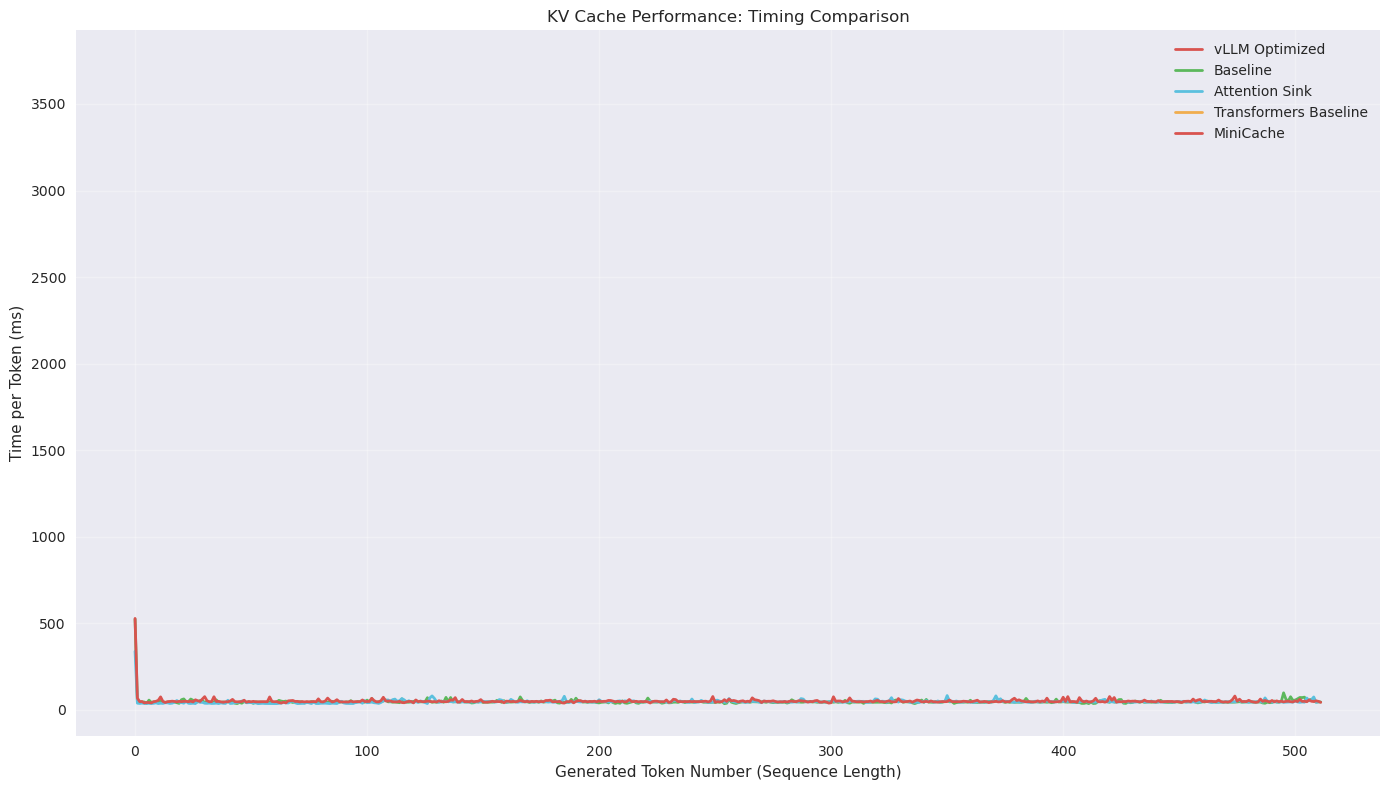

In [7]:
if results:
    # Plot timing comparison
    plotter.plot_timing_comparison(results, show_plot=True)
else:
    print("No results to plot.")

## VRAM Usage Analysis

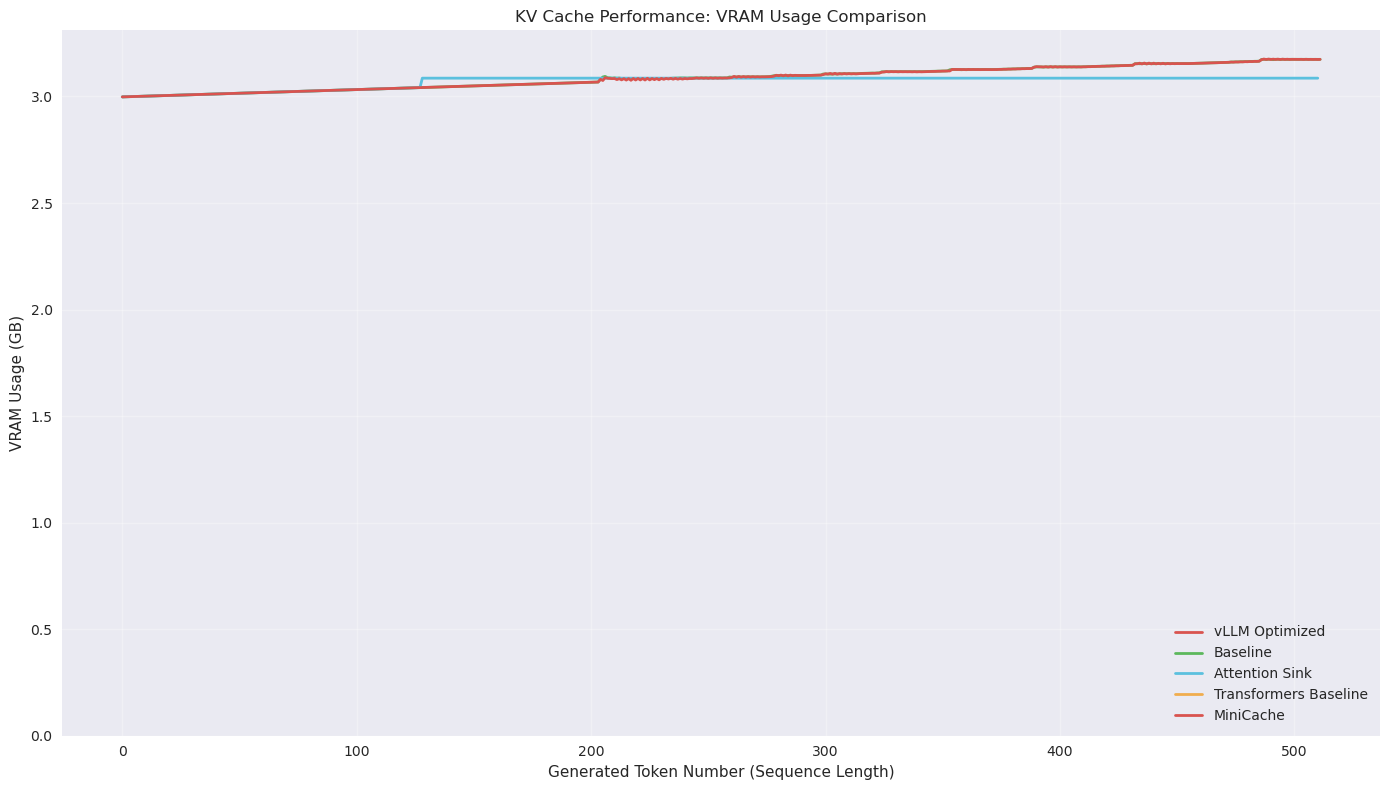

In [8]:
if results:
    # Plot VRAM comparison
    plotter.plot_vram_comparison(results, show_plot=True)
else:
    print("No results to plot.")

## Combined Performance Analysis

In [ ]:
if results:
    # Plot combined analysis
    plotter.plot_combined_analysis(results, show_plot=True)
else:
    print("No results to plot.")

## Performance Bar Charts

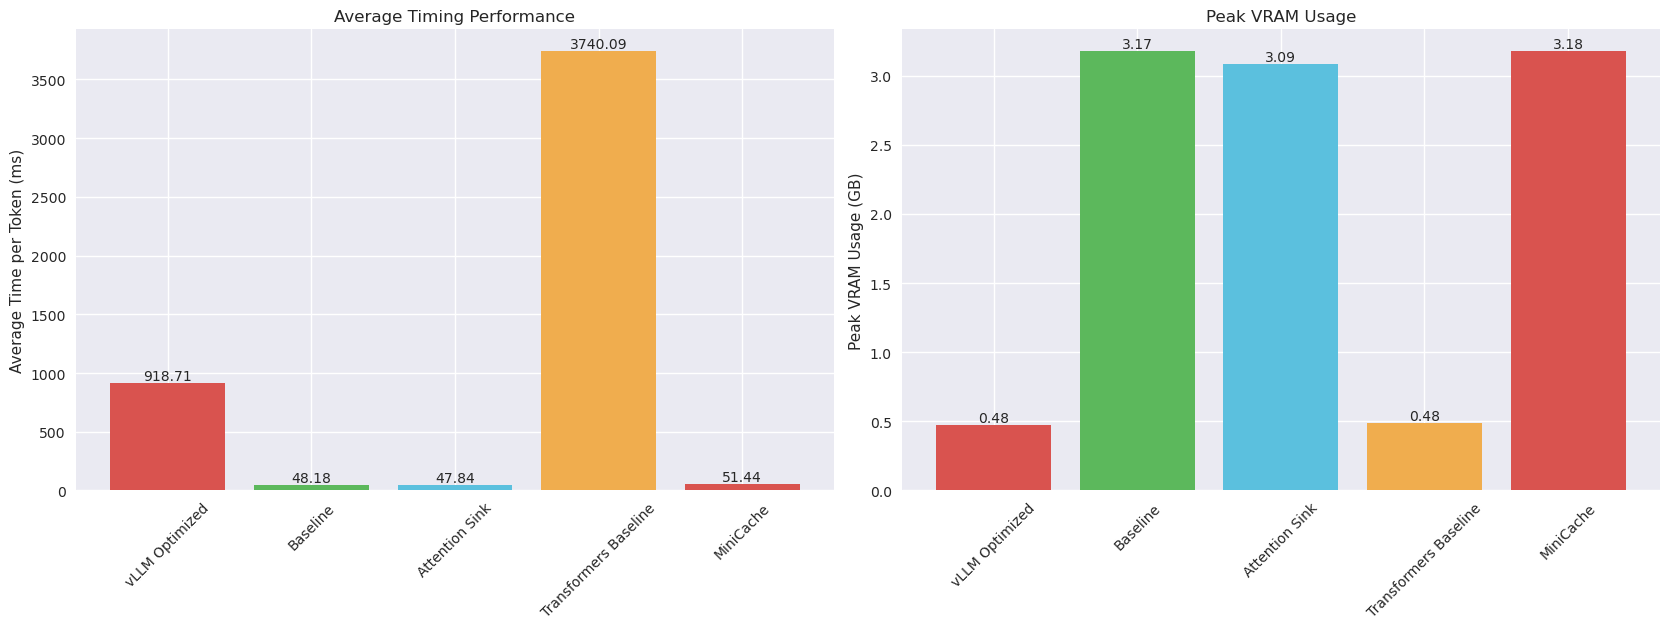

In [9]:
if results:
    # Plot performance bars
    plotter.plot_performance_bars(results, show_plot=True)
else:
    print("No results to plot.")

## Throughput Comparison (Memory Optimizers)

In [ ]:
if results:
    # Plot throughput comparison for memory optimizers
    plotter.plot_throughput_comparison(results, show_plot=True)
else:
    print("No results to plot.")

## Interactive Analysis

In [ ]:
# Interactive analysis section
if results:
    print("Available experiments for detailed analysis:")
    for i, name in enumerate(results.keys()):
        print(f"{i+1}. {name}")
    
    # You can select specific experiments for detailed analysis
    selected_experiments = list(results.keys())  # Analyze all by default
    
    print(f"\nAnalyzing {len(selected_experiments)} experiments...")
    
    # Create detailed statistics
    for name in selected_experiments:
        result = results[name]
        print(f"\n{name} - Detailed Statistics:")
        print("-" * 40)
        
        if result.timings:
            timings_array = np.array(result.timings)
            print(f"Timing Statistics (ms/token):")
            print(f"  Mean: {np.mean(timings_array):.2f}")
            print(f"  Median: {np.median(timings_array):.2f}")
            print(f"  Std Dev: {np.std(timings_array):.2f}")
            print(f"  Min: {np.min(timings_array):.2f}")
            print(f"  Max: {np.max(timings_array):.2f}")
        
        if result.vram_usage:
            vram_array = np.array(result.vram_usage)
            print(f"VRAM Statistics (GB):")
            print(f"  Peak: {np.max(vram_array):.2f}")
            print(f"  Mean: {np.mean(vram_array):.2f}")
            print(f"  Initial: {vram_array[0]:.2f}")
            print(f"  Final: {vram_array[-1]:.2f}")
            print(f"  Growth: {vram_array[-1] - vram_array[0]:.2f}")
else:
    print("No results available for analysis.")

## Save All Plots

In [ ]:
if results:
    print("Saving all plots to disk...")
    
    # Create all plots and save them
    plotter.create_all_plots(results, save_dir=PLOTS_DIR, show_plots=False)
    
    # Create and save summary report
    report_path = os.path.join(RESULTS_DIR, "summary_report.txt")
    report = create_summary_report(results, report_path)
    
    print(f"\nAll plots saved to: {PLOTS_DIR}")
    print(f"Summary report saved to: {report_path}")
    
    # List all generated files
    plot_files = glob.glob(os.path.join(PLOTS_DIR, "*.png"))
    print(f"\nGenerated {len(plot_files)} plot files:")
    for file in sorted(plot_files):
        print(f"  - {os.path.basename(file)}")
else:
    print("No results available to save.")

## Custom Analysis Section

Use this section for custom analysis and experiments.

In [ ]:
# Custom analysis - modify as needed
if results:
    # Example: Compare efficiency (inverse of timing)
    efficiency_data = []
    
    for name, result in results.items():
        avg_timing = result.get_average_timing()
        efficiency = 1000 / avg_timing if avg_timing > 0 else 0  # tokens per second
        efficiency_data.append({'Experiment': name, 'Efficiency (tokens/sec)': efficiency})
    
    efficiency_df = pd.DataFrame(efficiency_data)
    efficiency_df = efficiency_df.sort_values('Efficiency (tokens/sec)', ascending=False)
    
    print("EFFICIENCY RANKING (tokens/second):")
    print("=" * 40)
    for i, row in efficiency_df.iterrows():
        print(f"{row['Experiment']}: {row['Efficiency (tokens/sec)']:.2f}")
    
    # Plot efficiency comparison
    plt.figure(figsize=(12, 6))
    plt.bar(efficiency_df['Experiment'], efficiency_df['Efficiency (tokens/sec)'])
    plt.title('Efficiency Comparison (Higher is Better)')
    plt.ylabel('Tokens per Second')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No results available for custom analysis.")

## Conclusion

This notebook provides comprehensive analysis of KV cache optimization techniques. Key insights:

1. **Baseline Performance**: Establishes the reference point for all comparisons
2. **Attention Sink**: Reduces memory usage while maintaining reasonable performance
3. **MiniCache**: Optimizes cache sharing across transformer layers
4. **Memory Optimizers**: Compare different inference engines (vLLM vs Transformers)

The results demonstrate the trade-offs between memory efficiency and computational performance across different optimization strategies.